In [14]:
# ======================================================================
# 1. INSTALLATIONS AND IMPORTS
# ======================================================================

!pip install torch torchvision timm matplotlib scikit-learn seaborn

import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)

import timm



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# ======================================================================
# 2. LOAD DATASET AND INITIALIZE FOLDERS
# ======================================================================

TRAIN_DIR = r"F:\Machine Learning 445\skin_cancer_balanced\Train"
VAL_DIR   = r"F:\Machine Learning 445\skin_cancer_balanced\validation"
TEST_DIR  = r"F:\Machine Learning 445\skin_cancer_balanced\test"

BATCH_SIZE = 32
IMG_SIZE = 240    # EfficientNet-B1 recommended size


In [16]:
# ======================================================================
# 3. TRANSFORMS, DATASETS & DATALOADERS
# ======================================================================

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.ToTensor(),
])

test_val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=test_val_transform)
test_ds  = datasets.ImageFolder(TEST_DIR, transform=test_val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.classes
num_classes = len(class_names)

print("Classes:", class_names)


Classes: ['actinic_keratoses', 'basal_cell_carcinoma', 'benign_keratosis-like_lesions', 'dermatofibroma', 'melanocytic_Nevi', 'melanoma', 'vascular_lesions']


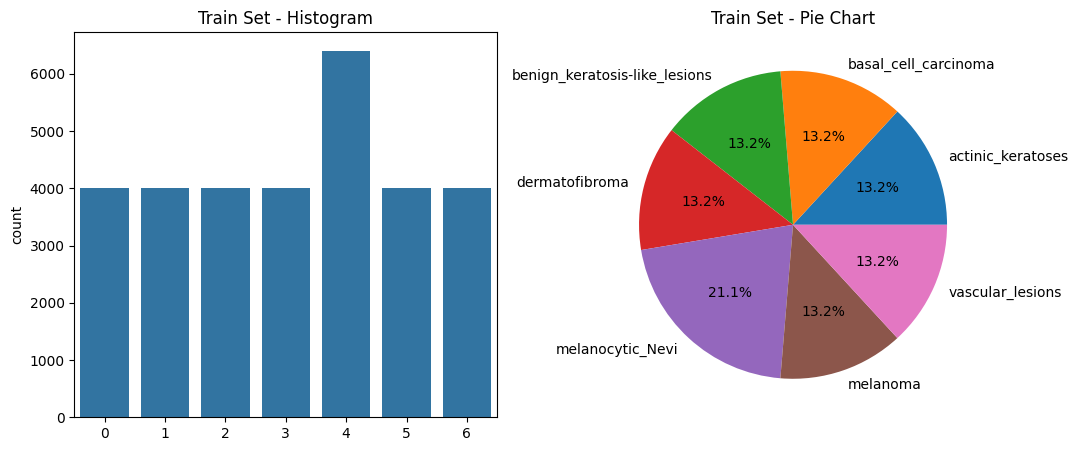

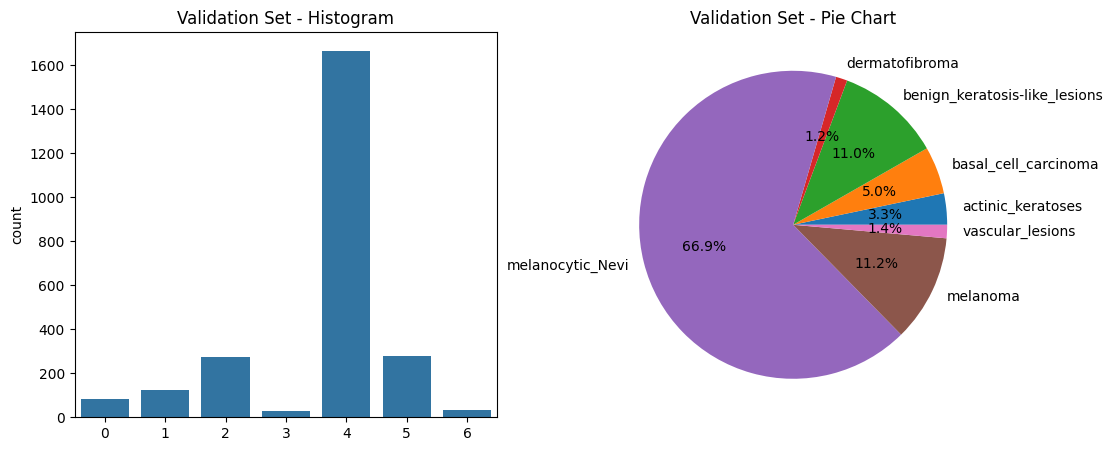

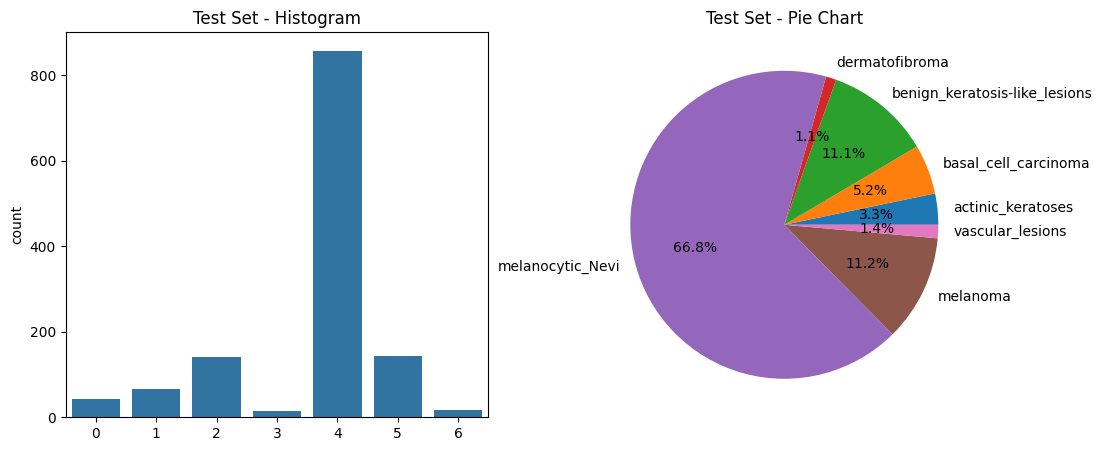

In [17]:
# ======================================================================
# 4. CLASS DISTRIBUTION VISUALIZATION
# ======================================================================

def plot_class_distribution(dataset, title):
    labels = [label for _, label in dataset.samples]
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(x=labels)
    plt.title(f"{title} - Histogram")

    plt.subplot(1, 2, 2)
    plt.pie(np.bincount(labels), labels=class_names, autopct='%1.1f%%')
    plt.title(f"{title} - Pie Chart")

    plt.show()

plot_class_distribution(train_ds, "Train Set")
plot_class_distribution(val_ds,  "Validation Set")
plot_class_distribution(test_ds, "Test Set")


In [18]:
# ======================================================================
# 5. FOCAL LOSS DEFINITION
# ======================================================================

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        pt = torch.exp(-ce_loss)
        focal = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return torch.mean(focal)


In [19]:
# ======================================================================
# 6. MODEL SETUP (EFFNET-B1 + DROPOUT + LAYER FREEZING)
# ======================================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("efficientnet_b1", pretrained=True, drop_rate=0.40)

# Replace classifier
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

model.to(device)

# -----------------------
# LAYER FREEZING STAGE 1
# -----------------------
# Freeze feature extractor first (train classifier only)
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

focal_loss = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)


In [20]:
# ======================================================================
# 7. TRAINING LOOP + EARLY STOPPING + TIME
# ======================================================================

EPOCHS = 40
patience = 5
best_val_loss = float('inf')
patience_counter = 0

best_model_path = "efficientnet_b1_best.pth"

train_losses, val_losses = [], []
train_accs, val_accs = [], []

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Training
    model.train()
    correct, total = 0, 0
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = focal_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_losses.append(running_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = focal_loss(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("✔ Best Model Saved!")
    else:
        patience_counter += 1
        print(f"⚠ Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("\n⛔ Early Stopping Triggered!")
            break

end_time = time.time()
print(f"\n⏱ Total Training Time: {(end_time - start_time)/60:.2f} minutes")



Epoch 1/40
Train Loss: 959.4319 | Train Acc: 0.4655
Val Loss:   28046769.2198 | Val Acc:   0.6838
✔ Best Model Saved!

Epoch 2/40
Train Loss: 736.8466 | Train Acc: 0.5597
Val Loss:   858194845.3815 | Val Acc:   0.6958
⚠ Patience: 1/5

Epoch 3/40
Train Loss: 688.7183 | Train Acc: 0.5755
Val Loss:   75983638941.3816 | Val Acc:   0.7014
⚠ Patience: 2/5

Epoch 4/40
Train Loss: 655.1404 | Train Acc: 0.5897
Val Loss:   14269687.5104 | Val Acc:   0.7099
✔ Best Model Saved!

Epoch 5/40
Train Loss: 642.1812 | Train Acc: 0.5919
Val Loss:   6657563716.1699 | Val Acc:   0.7075
⚠ Patience: 1/5

Epoch 6/40
Train Loss: 631.7393 | Train Acc: 0.5951
Val Loss:   1597333614950.2654 | Val Acc:   0.7159
⚠ Patience: 2/5

Epoch 7/40
Train Loss: 621.1194 | Train Acc: 0.6024
Val Loss:   2960311897.0650 | Val Acc:   0.7143
⚠ Patience: 3/5

Epoch 8/40
Train Loss: 611.3629 | Train Acc: 0.6030
Val Loss:   18501952801.4278 | Val Acc:   0.7183
⚠ Patience: 4/5

Epoch 9/40
Train Loss: 614.1685 | Train Acc: 0.6071
Val

In [21]:
# ======================================================================
# 8. FINE-TUNING (UNFREEZE ALL LAYERS)
# ======================================================================

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [22]:
# ======================================================================
# 9. LOAD BEST CHECKPOINT
# ======================================================================

model.load_state_dict(torch.load(best_model_path))
model.eval()


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [23]:
# ======================================================================
# 10. TEST SET METRICS
# ======================================================================

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)

print(f"\n🎯 Test Accuracy: {acc}")
print(f"📌 Precision: {prec}")
print(f"📌 Recall: {rec}")
print(f"📌 F1 Score: {f1}")



🎯 Test Accuracy: 0.7143968871595331
📌 Precision: 0.6791489182364252
📌 Recall: 0.7143968871595331
📌 F1 Score: 0.6621692556955289


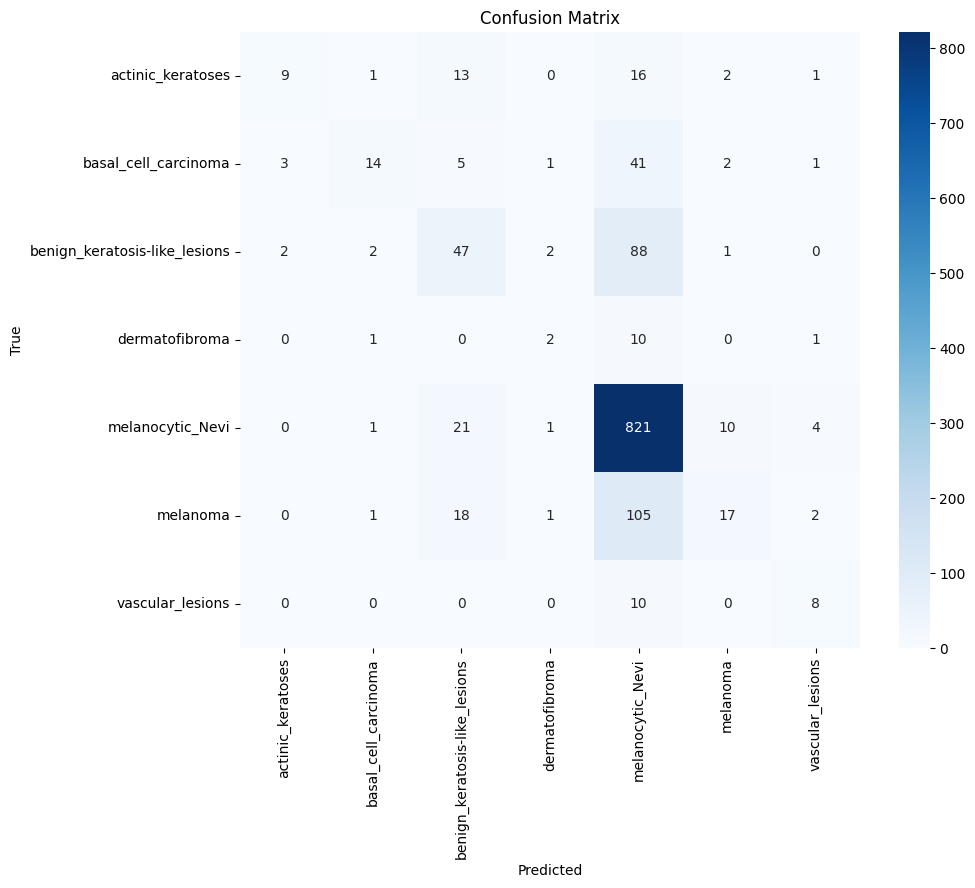

In [24]:
# ======================================================================
# 11. CONFUSION MATRIX
# ======================================================================

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


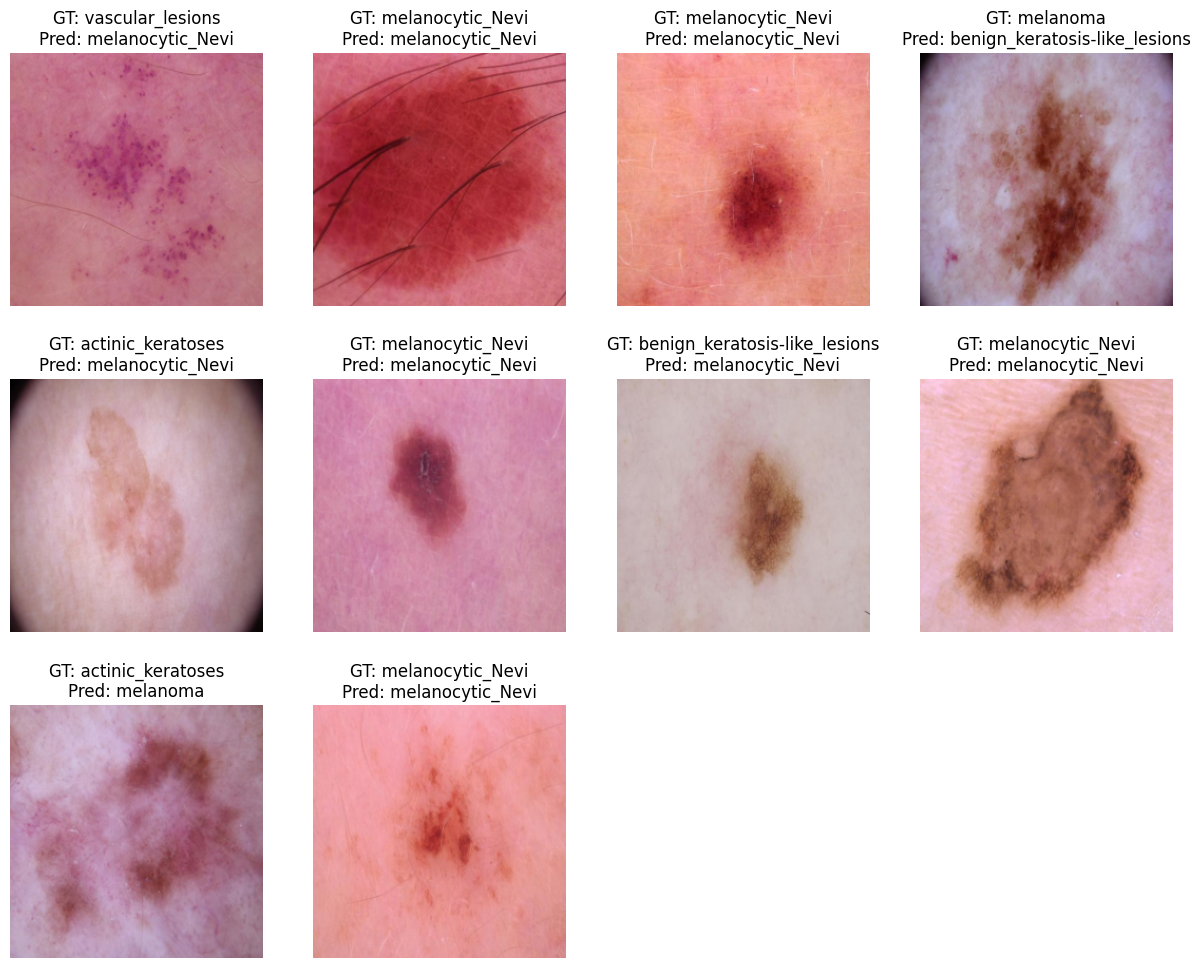

In [26]:
# ======================================================================
# 12. RANDOM TEST SAMPLE PREDICTION
# ======================================================================

indices = random.sample(range(len(test_ds)), 10)

plt.figure(figsize=(15, 12))

for i, idx in enumerate(indices):
    img, label = test_ds[idx]
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)

    plt.subplot(3, 4, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"GT: {class_names[label]}\nPred: {class_names[pred]}")
plt.show()


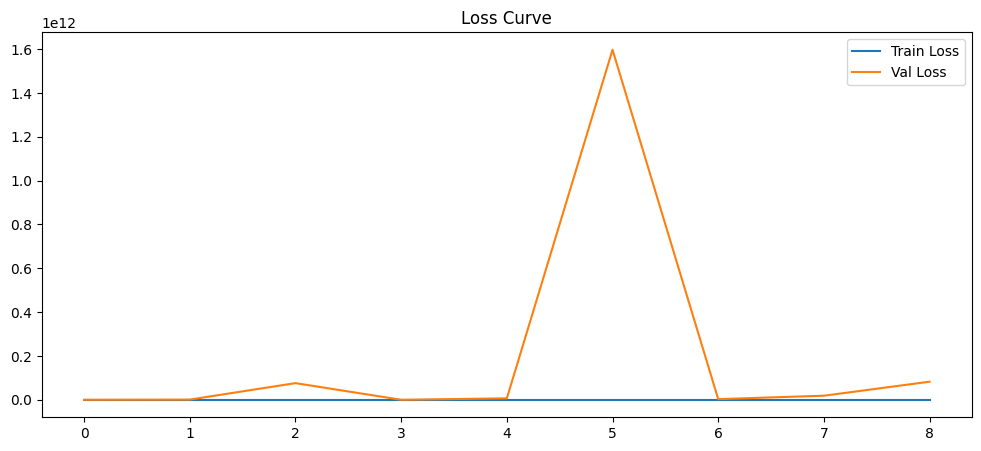

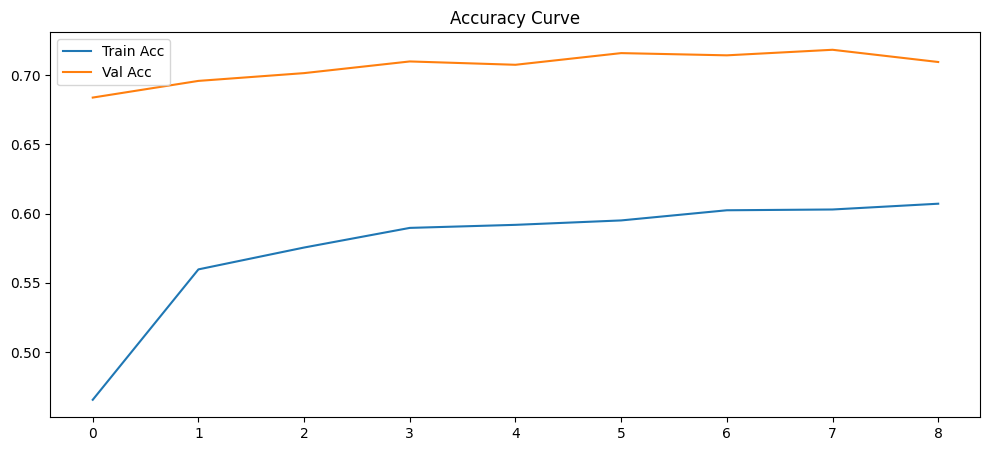

In [27]:
# ======================================================================
# 13. TRAINING STATISTICS VISUALIZATION
# ======================================================================

plt.figure(figsize=(12, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss Curve"); plt.show()

plt.figure(figsize=(12, 5))
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend(); plt.title("Accuracy Curve"); plt.show()
